# Monkeypox classification System

# Table of Contents
1.[Installing the required libraries](#1.-Installing-the-required-libraries)
    
2.[Initialize an ImageDataGenerator for dataSET with pixel value rescaling ](#2--initialize-an-imagedatagenerator-for-dataset-with-pixel-value-rescaling)

3.[Loading and transforming the dataset from the specified directory.](#3-loading-and-transforming-the-dataset-from-the-specified-directory)

4.[ EDA ](#4--eda)

5.[ Model Implementation ](#5--model-implementation)

5.1. [Customized CNN](#51-customized-cnn)

5.2. [VGG19](#52vgg19)

5.3. [VGG16](#53-vgg16)

5.4. [ResNet50](#54resnet50)

6.[Comparing Different Models Test Accuracies](#6--comparing-different-models-test-accuracies)

## 1- Installing the required libraries

In [3]:
# Necessary layers for building the model from Keras
from keras.layers import Input, Dense, Flatten, Dropout

# The Model class from Keras to create a model
from keras.models import Model

# Pre-trained models VGG19 and VGG16 from Keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

# The pre-trained ResNet50 model from TensorFlow's Keras applications
from tensorflow.keras.applications.resnet50 import ResNet50

# Tools for image processing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# The Sequential model type from Keras, which is a linear stack of layers
from keras.models import Sequential

# NumPy for numerical operations on arrays
import numpy as np

# Pandas for data manipulation and analysis
import pandas as pd

# Matplotlib's pyplot to plot graphs
import matplotlib.pyplot as plt
import plotly.express as px

# Importing required classes from TensorFlow's Keras API
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Flatten, Dropout)


## 2- Initialize an ImageDataGenerator for dataSET with pixel value rescaling 

In [4]:
# This generator scales the pixel values from a range of 0-255 to 0-1 to facilitate model 
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


## 3-Loading and transforming the dataset from the specified directory.

This sets the image size to 224x224, batch size to 32, and specifies binary classification.

The class mode is set to 'binary' indicating binary classification.

In [5]:
# Loading and transforming 

training_set = train_datagen.flow_from_directory('AI-project/dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary', subset="training")


test_set = test_datagen.flow_from_directory('AI-project/dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

val_set = valid_datagen.flow_from_directory('AI-project/dataset/Val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')


Found 2142 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [6]:
# Retrieve the class labels 
train_y = training_set.classes

test_y = test_set.classes

val_y = val_set.classes


In [7]:
# Retrieve a dictionary mapping class labels to their corresponding integer index
class_indices = training_set.class_indices
class_indices

{'Monkeypox': 0, 'Others': 1}

In [8]:
#Chaking the shape of the data
train_y.shape,test_y.shape,val_y.shape

((2142,), (45,), (420,))

## 4- EDA

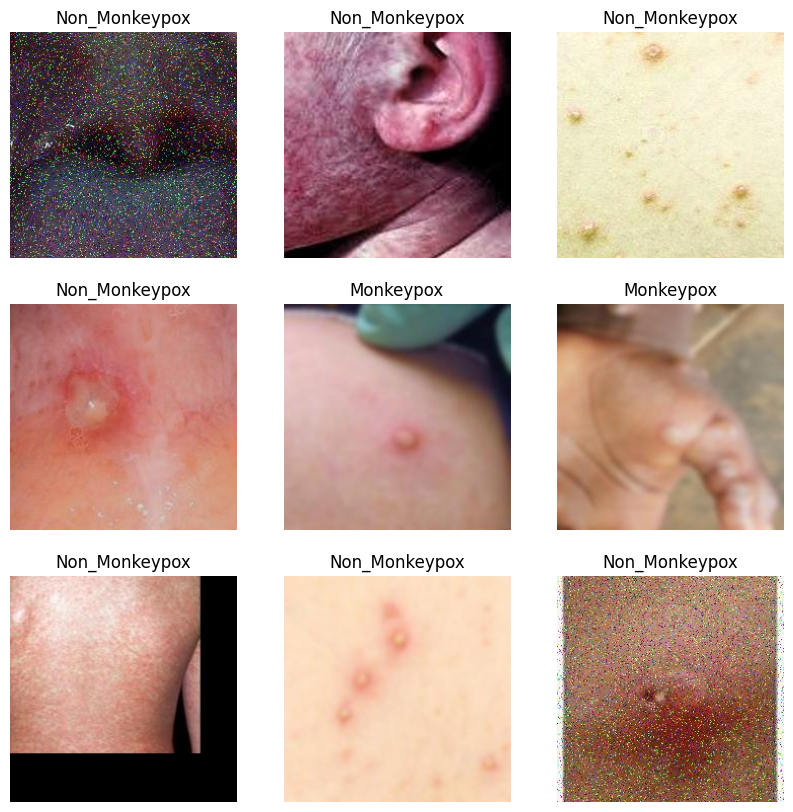

In [9]:
def show_examples(data_iterator, class_labels):
    plt.figure(figsize=(10, 10))  # Set up a figure with a size of 10x10 inches for displaying images
    batch = next(data_iterator)  # Get a batch of images from the iterator
    images, labels = batch[0], batch[1]  # Separate the batch into images and labels

    # Rescale images back to 0-255 range and convert to integer type for display
    images = images * 255.0
    images = images.astype('uint8')
    
    for i in range(9):  # Loop over the first 9 images in the batch to display them
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image in a 3x3 grid
        if images[i].shape[2] == 1:  # Check if the image is grayscale (single channel)
            plt.imshow(images[i][:,:,0], cmap='gray')  # Display grayscale images correctly
        else:
            plt.imshow(images[i])  # Display color images
        plt.title(class_labels[int(labels[i])])  # Set the title of each subplot to the corresponding class label
        plt.axis("off")  # Turn off axis labels and ticks
    plt.show()  # Display the figure with the images

# Call the function to display examples from the training set
show_examples(training_set, ["Monkeypox", "Non_Monkeypox"])


In [16]:

def count_images(directory):
    """Counts images in each subdirectory and returns a DataFrame."""
    classes = {}
    # Loop through each folder in the directory
    for folder in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder)):
            classes[folder] = len(os.listdir(os.path.join(directory, folder)))
    return pd.DataFrame(list(classes.items()), columns=['Class', 'Count'])

# Specify your directories here
directories = {
    'Train': 'AI-project/dataset/Train',
    'Validation': 'AI-project/dataset/Val',
    'Test': 'AI-project/dataset/Test'
}

# Process each directory and create a DataFrame
all_data = []
for key, path in directories.items():
    df = count_images(path)
    df['Dataset'] = key
    all_data.append(df)

# Combine all data into a single DataFrame
final_df = pd.concat(all_data)

# Plotting
fig = px.bar(final_df, x='Class', y='Count', color='Dataset', barmode='group',
             title='Distribution of Classes Across Datasets')
fig.show()


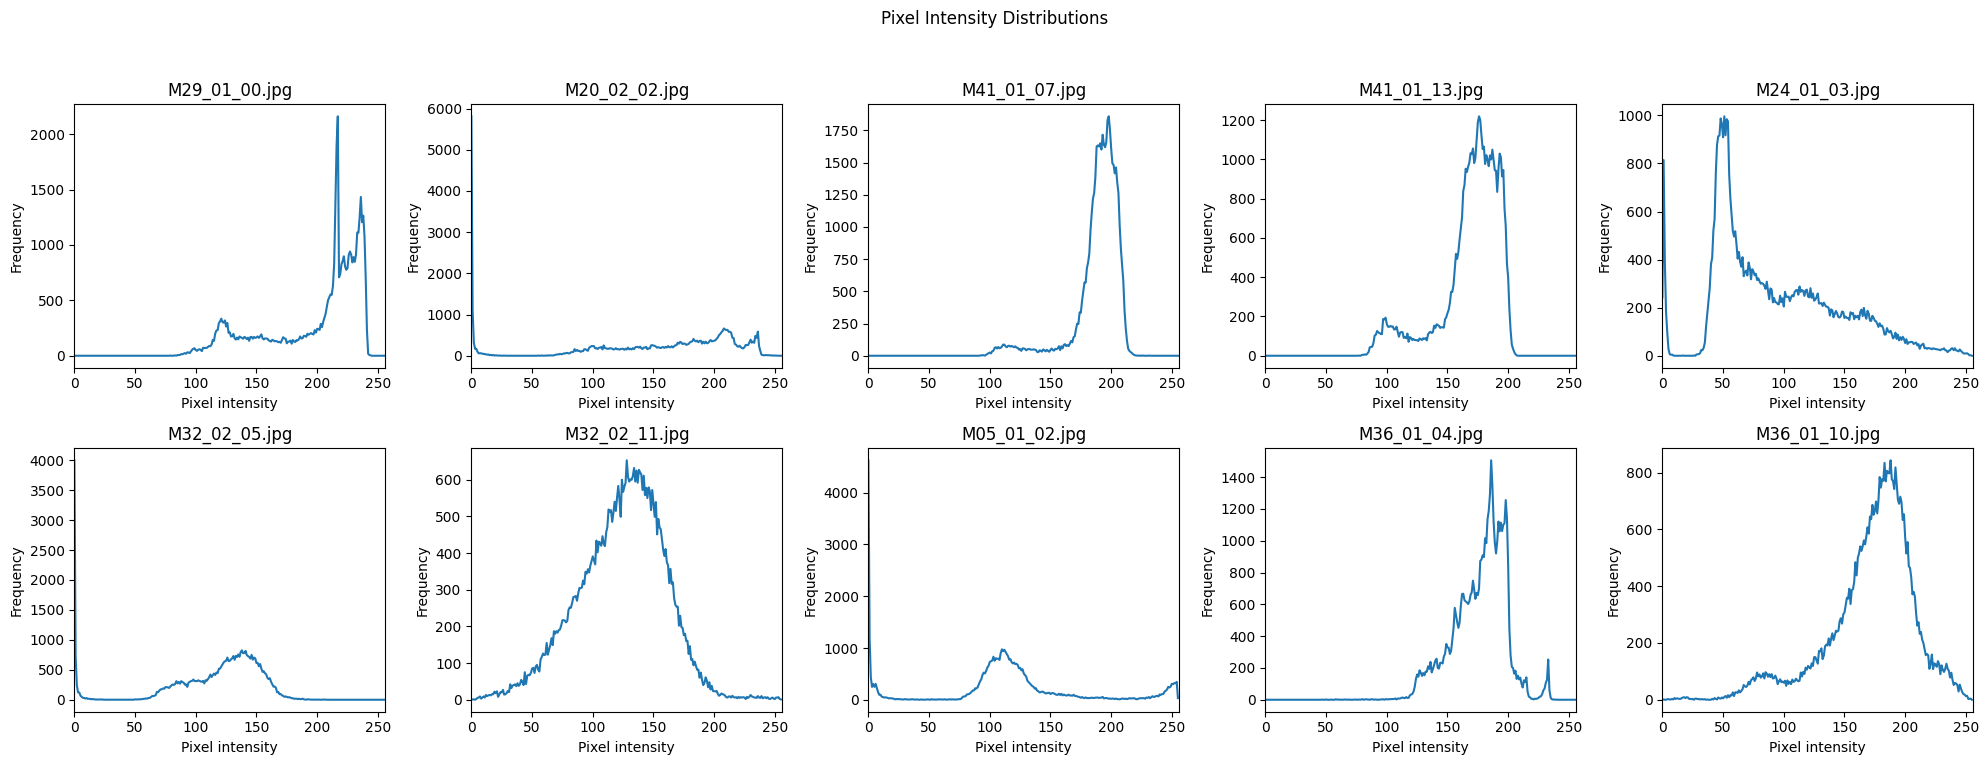

In [28]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def plot_pixel_intensity_distribution(image_path, ax):
    try:
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        img_array = np.array(img)
        histogram, bin_edges = np.histogram(img_array, bins=256, range=(0, 256))
        
        # Use the provided axes to plot the histogram
        ax.plot(bin_edges[0:-1], histogram)
        ax.set_xlim([0, 256])
        ax.set_title(f"{os.path.basename(image_path)}")
        ax.set_xlabel("Pixel intensity")
        ax.set_ylabel("Frequency")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Example usage
image_directory = 'AI-project/dataset/Train/Monkeypox'
images = [img for img in os.listdir(image_directory) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
images = images[:10]  # Limit the number of images to 20 for demonstration

fig, axs = plt.subplots(nrows=(len(images) // 5 + (len(images) % 5 > 0)), ncols=5, figsize=(20, 4 * (len(images) // 5 + (len(images) % 5 > 0))))
fig.suptitle('Pixel Intensity Distributions')

# Flatten the axis array and hide unused subplots if any
axs = axs.flatten()
for ax in axs[len(images):]:
    ax.set_visible(False)

# Plot histograms
for idx, image_filename in enumerate(images):
    image_path = os.path.join(image_directory, image_filename)
    plot_pixel_intensity_distribution(image_path, axs[idx])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplots to fit into figure area.
plt.show()


## 5- Model implementation

### 5.1. CUSTOMIZED CNN

In [98]:

# Initializing a sequential model. Sequential models are a linear stack of layers.
model = Sequential()

# Adding a 2D convolutional layer with 32 filters, a 3x3 kernel size, and ReLU activation.
# This layer will extract features from the input image.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

# Adding a max pooling layer that reduces the spatial dimensions (height and width) of the input.
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# Adding another 2D convolutional layer, now with 64 filters.
model.add(Conv2D(64, (3, 3), activation='relu'))

# Adding another max pooling layer to further reduce the spatial dimensions.
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# Adding a third convolutional layer with 128 filters to extract more complex features.
model.add(Conv2D(128, (3, 3), activation='relu'))

# Another max pooling layer follows.
model.add(MaxPool2D((2, 2), strides=(2, 2)))

# Flattening the output from the convolutional layers to form a single long feature vector.
model.add(Flatten())

# Adding a dense layer (fully connected layer) with 64 units/neurons and ReLU activation.
# This layer will process features extracted by the convolutional layers.
model.add(Dense(64, activation='relu'))

# Final output layer with a single neuron and sigmoid activation function.
# Since it uses sigmoid, the output will be in the range 0-1, appropriate for binary classification.
model.add(Dense(1, activation='sigmoid'))


In [99]:
# Compiling the model with the necessary parameters for training.
model.compile(
    loss='binary_crossentropy',  # Setting the loss function to 'binary_crossentropy' which is suitable for binary classification.
    optimizer="ADAM",            # Using the ADAM optimizer, a popular choice that combines the best properties of the AdaGrad and RMSprop algorithms to handle sparse gradients on noisy problems.
    metrics=['accuracy']         # Including 'accuracy' as a metric for evaluation. This will track the percentage of correctly predicted instances during training and testing.
)


In [100]:
#Early stopping to avoid overfitting of model
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [101]:
# Fit the model with the training data and also validate using the validation set.
history = model.fit(
   training_set,                  # Training data: images and labels.
   validation_data=val_set,       # Validation data: used to evaluate the model after each epoch to monitor overfitting.
   epochs=20,                     # The number of times to iterate over the entire training dataset.
   callbacks=[early_stop],        # Callbacks are used to perform actions at various stages of training (e.g., early stopping to prevent overfitting).
   batch_size=32,                 # Number of samples per gradient update. Since data generators are used, this parameter should typically be set in the generator or omitted.
   shuffle=True                   # Shuffle the order of batches at the beginning of each epoch.
)

# Note: The `batch_size` parameter here typically does not have any effect when using data generators like `training_set` and `val_set` as they handle batch sizing internally.


Epoch 1/20
67/67 [==============================] - 28s 412ms/step - loss: 0.7146 - accuracy: 0.5920 - val_loss: 0.6851 - val_accuracy: 0.6286
Epoch 2/20
67/67 [==============================] - 27s 405ms/step - loss: 0.6180 - accuracy: 0.6583 - val_loss: 0.7127 - val_accuracy: 0.6571
Epoch 3/20
67/67 [==============================] - 27s 405ms/step - loss: 0.5269 - accuracy: 0.7414 - val_loss: 0.8753 - val_accuracy: 0.5476
Epoch 4/20
67/67 [==============================] - 27s 405ms/step - loss: 0.4662 - accuracy: 0.7764 - val_loss: 0.9248 - val_accuracy: 0.5262
Epoch 5/20
67/67 [==============================] - 27s 407ms/step - loss: 0.4181 - accuracy: 0.8100 - val_loss: 0.9219 - val_accuracy: 0.5833
Epoch 6/20
67/67 [==============================] - 27s 410ms/step - loss: 0.3501 - accuracy: 0.8385 - val_loss: 1.0705 - val_accuracy: 0.5262
Epoch 6: early stopping


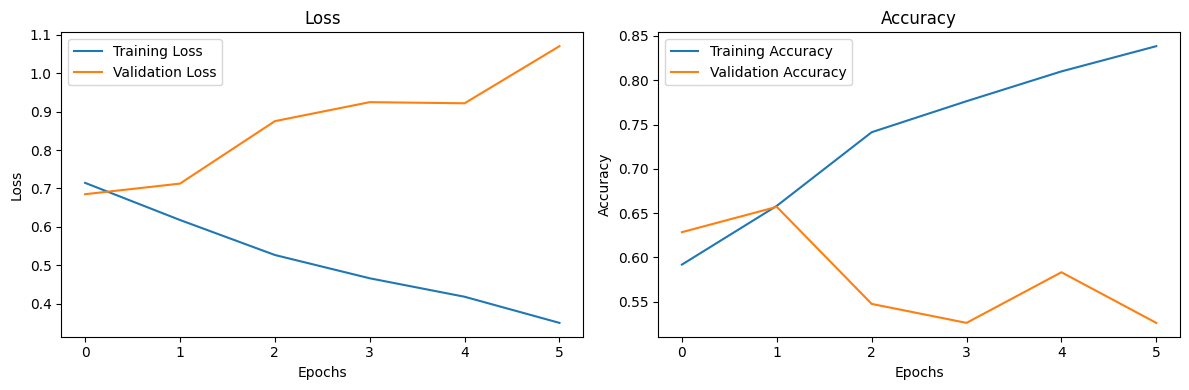

In [108]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjusted figsize for horizontal layout

# Plot loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [109]:
# Evaluate the model using the test dataset
score = model.evaluate_generator(test_set)
custom_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_5607/2371373596.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_set)


Test loss: 0.9041983485221863
Test accuracy: 0.7333333492279053


In [127]:
#Save the model
model.save('AI-project/model.keras')  


In [115]:
# Assume you have a function 'prepare_image' to process your input image
test_image = prepare_image('AI-project/dataset/Test/Monkeypox/M19_02.jpg')
if test_image is not None:
    test_image = np.expand_dims(test_image, axis=0)  # Add an extra dimension to match the model's input shape
    prediction = model.predict(test_image)

    # Output the prediction
    print(f"Predicted score: {prediction[0]}")
    if prediction[0] > 0.5:
        print("The image is classified as Monkeypox.")
    else:
        print("The image is classified as Non-Monkeypox.")
else:
    print("Failed to process the image.")


1/1 [==============================] - 0s 17ms/step
Predicted score: [0.6596486]
The image is classified as Monkeypox.
Failed to process the image.


1/1 [==============================] - 0s 168ms/step


/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_5607/102074935.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_labels = [class_labels[int(prediction)] for prediction in predictions]


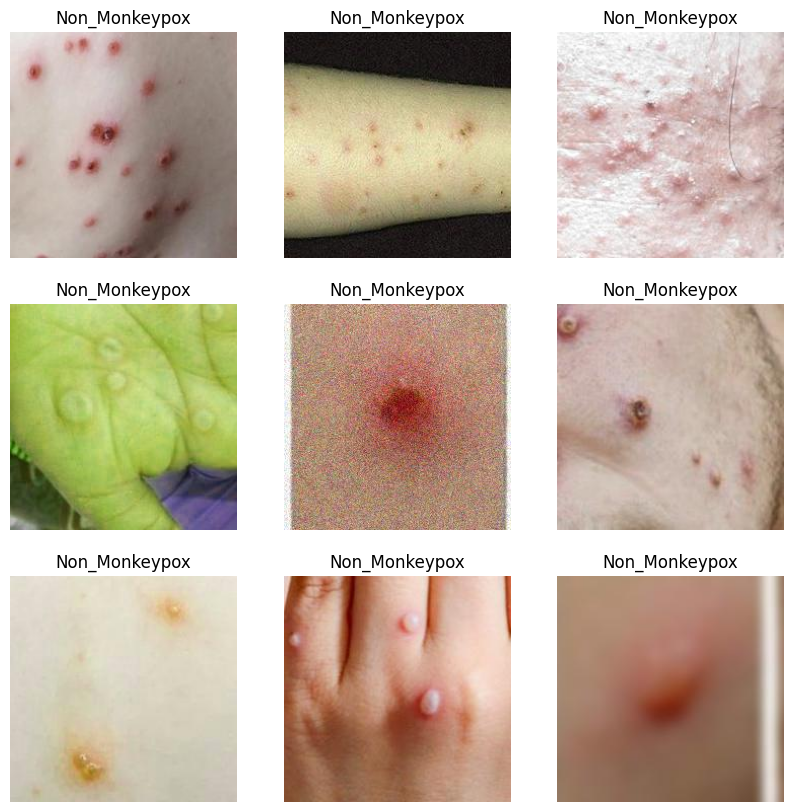

In [119]:

def show_examples(data_iterator, class_labels, model):
    plt.figure(figsize=(10, 10))  # Set up a figure with a size of 10x10 inches for displaying images
    batch = next(data_iterator)  # Get a batch of images from the iterator
    images, labels = batch[0], batch[1]  # Separate the batch into images and labels

    # Rescale images back to 0-255 range and convert to integer type for display
    images = images * 255.0
    images = images.astype('uint8')
    
    # Predict the labels using the model
    predictions = model.predict(images)
    predicted_labels = [class_labels[int(prediction)] for prediction in predictions]
    
    for i in range(9):  # Loop over the first 9 images in the batch to display them
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image in a 3x3 grid
        if images[i].shape[2] == 1:  # Check if the image is grayscale (single channel)
            plt.imshow(images[i][:,:,0], cmap='gray')  # Display grayscale images correctly
        else:
            plt.imshow(images[i])  # Display color images
        plt.title(predicted_labels[i])  # Set the title of each subplot to the predicted class label
        plt.axis("off")  # Turn off axis labels and ticks
    plt.show()  # Display the figure with the images

# Call the function to display examples from the training set using the saved model
show_examples(training_set, ["Monkeypox", "Non_Monkeypox"], model)


### 5.2.VGG19

In [122]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Load VGG19 base model
vgg19 = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in vgg19.layers:
    layer.trainable = False

# Adding custom layers
x = Flatten()(vgg19.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create the final model
model1 = Model(inputs=vgg19.input, outputs=prediction)
# Now the model is ready to be compiled and trained


In [123]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [124]:
model1.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [128]:
# fit the model
history1 = model1.fit(
 training_set,
  validation_data=val_set,
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
67/67 [==============================] - 267s 4s/step - loss: 0.2080 - accuracy: 0.9113 - val_loss: 1.3652 - val_accuracy: 0.5595
Epoch 2/50
67/67 [==============================] - 257s 4s/step - loss: 0.1330 - accuracy: 0.9440 - val_loss: 1.4621 - val_accuracy: 0.6810
Epoch 3/50
67/67 [==============================] - 259s 4s/step - loss: 0.1540 - accuracy: 0.9365 - val_loss: 1.1081 - val_accuracy: 0.6524
Epoch 4/50
67/67 [==============================] - 260s 4s/step - loss: 0.1079 - accuracy: 0.9617 - val_loss: 1.6793 - val_accuracy: 0.6119
Epoch 5/50
67/67 [==============================] - 262s 4s/step - loss: 0.0857 - accuracy: 0.9636 - val_loss: 2.3380 - val_accuracy: 0.6262
Epoch 6/50
67/67 [==============================] - 263s 4s/step - loss: 0.0845 - accuracy: 0.9645 - val_loss: 2.4188 - val_accuracy: 0.5857
Epoch 7/50
67/67 [==============================] - 264s 4s/step - loss: 0.0799 - accuracy: 0.9711 - val_loss: 2.9903 - val_accuracy: 0.5119
Epoch 8/50
67

In [130]:
score = model1.evaluate_generator(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_5607/4183795782.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model1.evaluate_generator(test_set)


Test loss: 1.5999608039855957
Test accuracy: 0.644444465637207


In [129]:
#Save the model
model.save('AI-project/model1.keras')  


In [11]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = 'AI-project/model1.keras'

# Load the model
model1 = load_model(model_path)



1/1 [==============================] - 0s 143ms/step


/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_1636/705540360.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_labels = [class_labels[int(prediction)] for prediction in predictions]


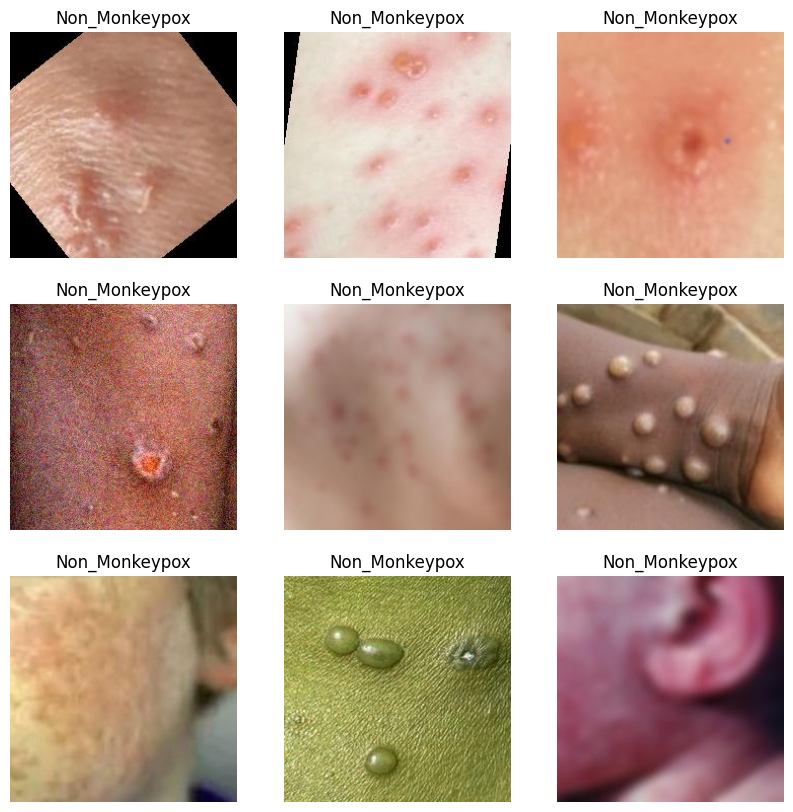

In [12]:

def show_examples(data_iterator, class_labels, model):
    plt.figure(figsize=(10, 10))  # Set up a figure with a size of 10x10 inches for displaying images
    batch = next(data_iterator)  # Get a batch of images from the iterator
    images, labels = batch[0], batch[1]  # Separate the batch into images and labels

    # Rescale images back to 0-255 range and convert to integer type for display
    images = images * 255.0
    images = images.astype('uint8')
    
    # Predict the labels using the model
    predictions = model.predict(images)
    predicted_labels = [class_labels[int(prediction)] for prediction in predictions]
    
    for i in range(9):  # Loop over the first 9 images in the batch to display them
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image in a 3x3 grid
        if images[i].shape[2] == 1:  # Check if the image is grayscale (single channel)
            plt.imshow(images[i][:,:,0], cmap='gray')  # Display grayscale images correctly
        else:
            plt.imshow(images[i])  # Display color images
        plt.title(predicted_labels[i])  # Set the title of each subplot to the predicted class label
        plt.axis("off")  # Turn off axis labels and ticks
    plt.show()  # Display the figure with the images

# Call the function to display examples from the training set using the saved model
show_examples(training_set, ["Monkeypox", "Non_Monkeypox"], model1)


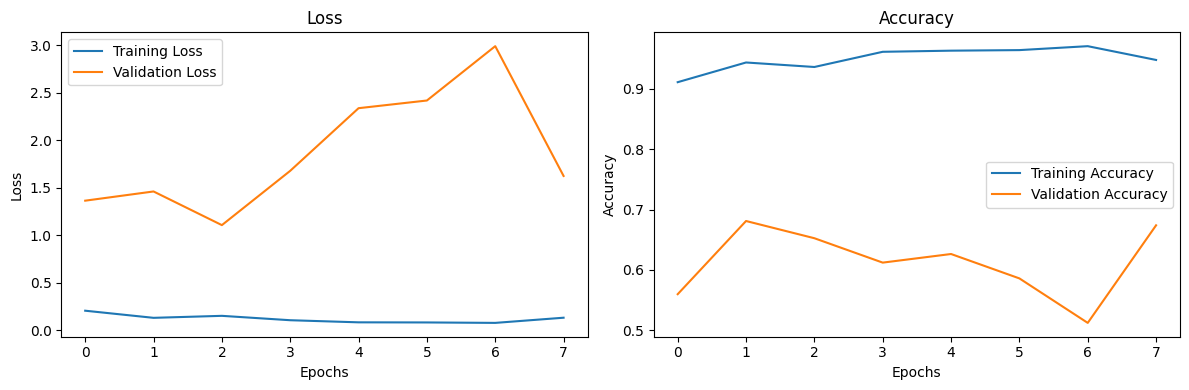

In [131]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjusted figsize for horizontal layout

# Plot loss
axs[0].plot(history1.history['loss'], label='Training Loss')
axs[0].plot(history1.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(history1.history['accuracy'], label='Training Accuracy')
axs[1].plot(history1.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [132]:
score = model1.evaluate_generator(test_set)
vgg19_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_5607/995498166.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model1.evaluate_generator(test_set)


Test loss: 1.5999608039855957
Test accuracy: 0.644444465637207


### 5.3. VGG16


In [133]:
vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [134]:
for layer in vgg16.layers:
    layer.trainable = False

In [135]:
x = Flatten()(vgg16.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

In [136]:
model3 = Model(inputs=vgg16.input, outputs=prediction)

In [137]:
# view the structure of the model
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [138]:
model3.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [140]:
# fit the model
history2 = model3.fit(
 training_set,
  validation_data=val_set,
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
67/67 [==============================] - 215s 3s/step - loss: 1.8255 - accuracy: 0.7241 - val_loss: 1.2145 - val_accuracy: 0.6357
Epoch 2/50
67/67 [==============================] - 216s 3s/step - loss: 0.3075 - accuracy: 0.8674 - val_loss: 1.5307 - val_accuracy: 0.5833
Epoch 3/50
67/67 [==============================] - 212s 3s/step - loss: 0.2103 - accuracy: 0.9150 - val_loss: 1.5243 - val_accuracy: 0.5690
Epoch 4/50
67/67 [==============================] - 212s 3s/step - loss: 0.2066 - accuracy: 0.9118 - val_loss: 1.7865 - val_accuracy: 0.6000
Epoch 5/50
67/67 [==============================] - 212s 3s/step - loss: 0.1683 - accuracy: 0.9328 - val_loss: 1.6309 - val_accuracy: 0.5786
Epoch 6/50
67/67 [==============================] - 213s 3s/step - loss: 0.1290 - accuracy: 0.9435 - val_loss: 2.1549 - val_accuracy: 0.6095
Epoch 6: early stopping


In [141]:
#Save the model
model.save('AI-project/model3.keras')  


In [1]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = 'AI-project/model3.keras'

# Load the model
model3 = load_model(model_path)



/Users/shodz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1/1 [==============================] - 0s 208ms/step


/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_1636/3644066713.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_labels = [class_labels[int(prediction)] for prediction in predictions]


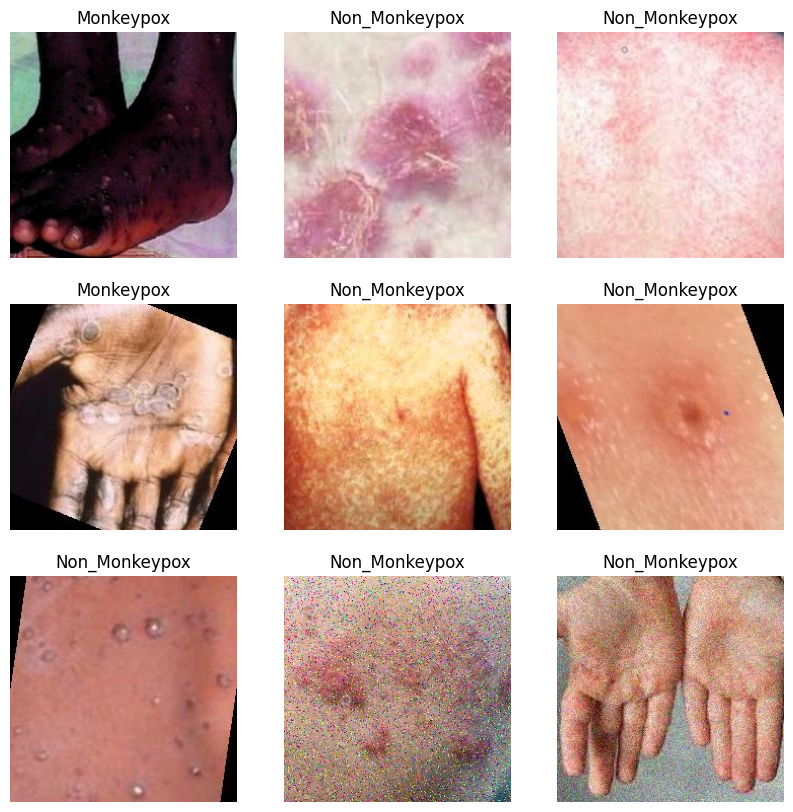

In [10]:

def show_examples(data_iterator, class_labels, model):
    plt.figure(figsize=(10, 10))  # Set up a figure with a size of 10x10 inches for displaying images
    batch = next(data_iterator)  # Get a batch of images from the iterator
    images, labels = batch[0], batch[1]  # Separate the batch into images and labels

    # Rescale images back to 0-255 range and convert to integer type for display
    images = images * 255.0
    images = images.astype('uint8')
    
    # Predict the labels using the model
    predictions = model.predict(images)
    predicted_labels = [class_labels[int(prediction)] for prediction in predictions]
    
    for i in range(9):  # Loop over the first 9 images in the batch to display them
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image in a 3x3 grid
        if images[i].shape[2] == 1:  # Check if the image is grayscale (single channel)
            plt.imshow(images[i][:,:,0], cmap='gray')  # Display grayscale images correctly
        else:
            plt.imshow(images[i])  # Display color images
        plt.title(predicted_labels[i])  # Set the title of each subplot to the predicted class label
        plt.axis("off")  # Turn off axis labels and ticks
    plt.show()  # Display the figure with the images

# Call the function to display examples from the training set using the saved model
show_examples(training_set, ["Monkeypox", "Non_Monkeypox"], model3)


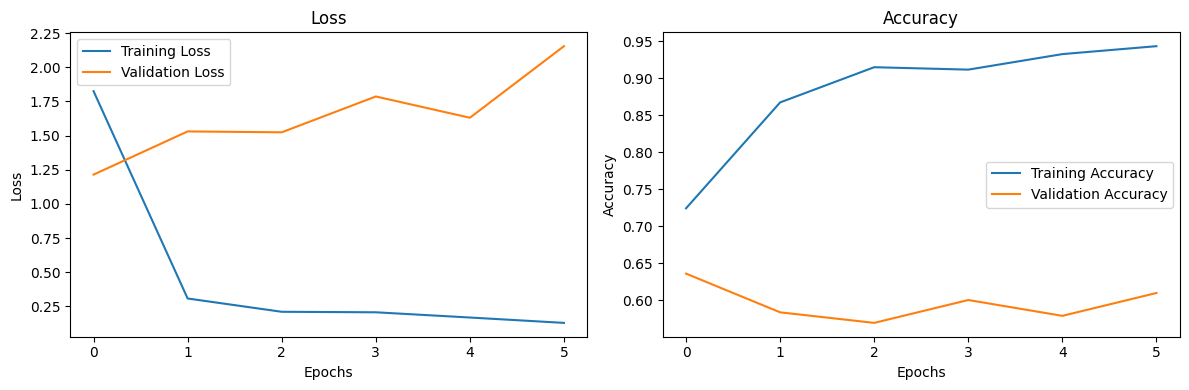

In [143]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjusted figsize for horizontal layout

# Plot loss
axs[0].plot(history2.history['loss'], label='Training Loss')
axs[0].plot(history2.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(history2.history['accuracy'], label='Training Accuracy')
axs[1].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [142]:
score = model3.evaluate_generator(test_set)
vgg16_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_5607/173921928.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model3.evaluate_generator(test_set)


Test loss: 1.3646142482757568
Test accuracy: 0.7777777910232544


### 5.4.RESNET50

In [144]:
resnet = ResNet50(input_shape=(224,224,3), weights=None, include_top=False)

In [145]:
for layer in resnet.layers:
    layer.trainable = False

In [146]:
x = Flatten()(resnet.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

In [147]:
model4 = Model(inputs=resnet.input, outputs=prediction)

In [148]:
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [149]:
model4.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [150]:
# fit the model
history3 = model4.fit(
 training_set,
  validation_data=val_set,
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
67/67 [==============================] - 269s 4s/step - loss: 1.1286 - accuracy: 0.5364 - val_loss: 0.6644 - val_accuracy: 0.6000
Epoch 2/50
67/67 [==============================] - 215s 3s/step - loss: 0.6934 - accuracy: 0.5453 - val_loss: 0.6558 - val_accuracy: 0.6310
Epoch 3/50
67/67 [==============================] - 205s 3s/step - loss: 0.6460 - accuracy: 0.6209 - val_loss: 0.6521 - val_accuracy: 0.6429
Epoch 4/50
67/67 [==============================] - 215s 3s/step - loss: 0.6302 - accuracy: 0.6396 - val_loss: 0.6375 - val_accuracy: 0.6548
Epoch 5/50
67/67 [==============================] - 217s 3s/step - loss: 0.6395 - accuracy: 0.6209 - val_loss: 0.6077 - val_accuracy: 0.6857
Epoch 6/50
67/67 [==============================] - 217s 3s/step - loss: 0.5887 - accuracy: 0.6802 - val_loss: 0.5903 - val_accuracy: 0.7190
Epoch 7/50
67/67 [==============================] - 201s 3s/step - loss: 0.6307 - accuracy: 0.6335 - val_loss: 0.6389 - val_accuracy: 0.6952
Epoch 8/50
67

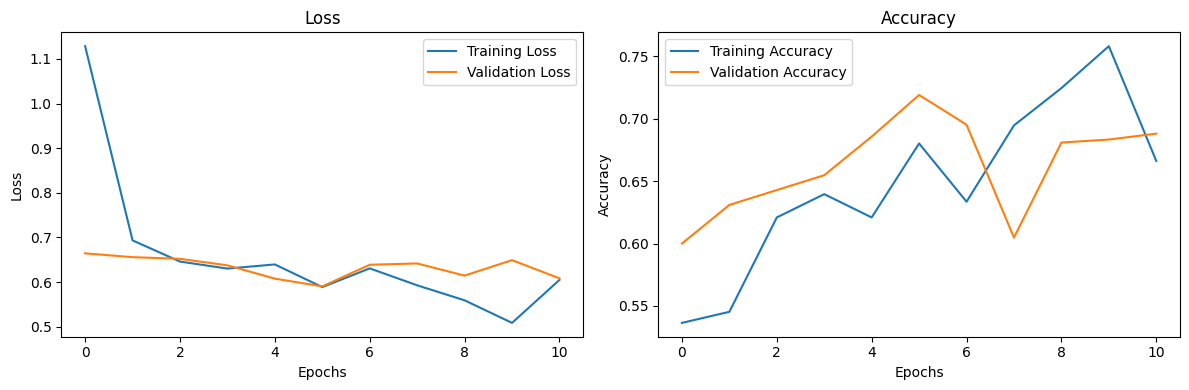

In [152]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Adjusted figsize for horizontal layout

# Plot loss
axs[0].plot(history3.history['loss'], label='Training Loss')
axs[0].plot(history3.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(history3.history['accuracy'], label='Training Accuracy')
axs[1].plot(history3.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [154]:
score = model4.evaluate_generator(test_set)
resnet_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_5607/2484976226.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model4.evaluate_generator(test_set)


Test loss: 0.6714792251586914
Test accuracy: 0.6666666865348816


In [151]:
#Save the model
model.save('AI-project/model4.keras')  


In [13]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = 'AI-project/model4.keras'

# Load the model
model4 = load_model(model_path)



1/1 [==============================] - 0s 142ms/step


/var/folders/4g/tyxt36t547j_n6f0ft31746r0000gn/T/ipykernel_1636/2889352363.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_labels = [class_labels[int(prediction)] for prediction in predictions]


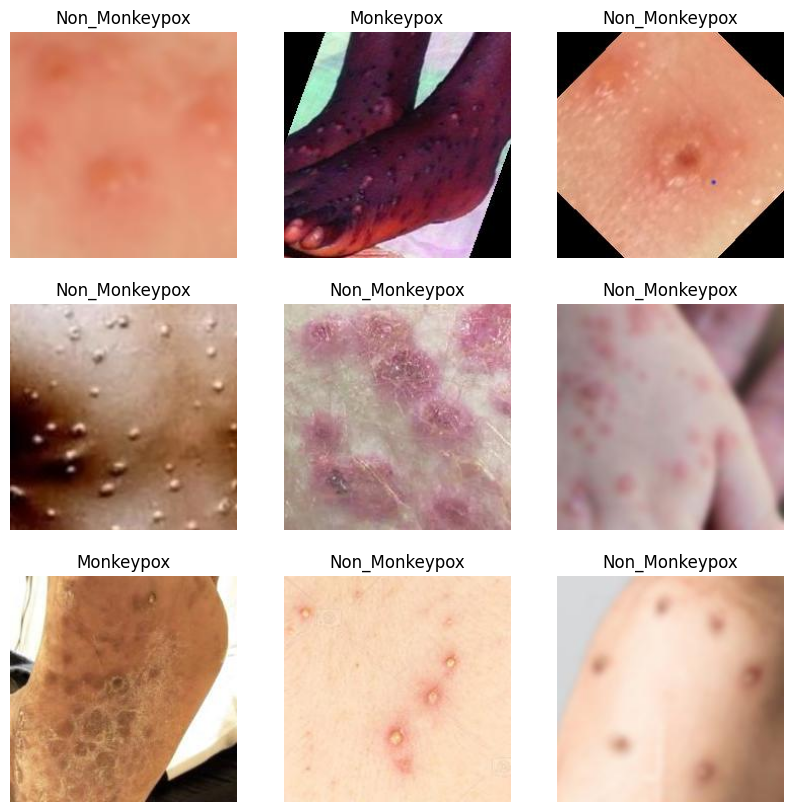

In [14]:

def show_examples(data_iterator, class_labels, model):
    plt.figure(figsize=(10, 10))  # Set up a figure with a size of 10x10 inches for displaying images
    batch = next(data_iterator)  # Get a batch of images from the iterator
    images, labels = batch[0], batch[1]  # Separate the batch into images and labels

    # Rescale images back to 0-255 range and convert to integer type for display
    images = images * 255.0
    images = images.astype('uint8')
    
    # Predict the labels using the model
    predictions = model.predict(images)
    predicted_labels = [class_labels[int(prediction)] for prediction in predictions]
    
    for i in range(9):  # Loop over the first 9 images in the batch to display them
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image in a 3x3 grid
        if images[i].shape[2] == 1:  # Check if the image is grayscale (single channel)
            plt.imshow(images[i][:,:,0], cmap='gray')  # Display grayscale images correctly
        else:
            plt.imshow(images[i])  # Display color images
        plt.title(predicted_labels[i])  # Set the title of each subplot to the predicted class label
        plt.axis("off")  # Turn off axis labels and ticks
    plt.show()  # Display the figure with the images

# Call the function to display examples from the training set using the saved model
show_examples(training_set, ["Monkeypox", "Non_Monkeypox"], model4)


# 6- Comparing Different Model's Test Accuracies

In [156]:

# Data preparation
data = {'Custom CNN': custom_accu, 'VGG16': vgg16_accu, 'VGG19': vgg19_accu, 'RESNET50': resnet_accu}
df = pd.DataFrame(list(data.items()), columns=['Model', 'Accuracy'])

# Creating a bar chart using Plotly Express
fig = px.bar(df, x='Model', y='Accuracy', 
             title="Comparing Different Model's Test Accuracies",
             color='Model',  # Color coding the bars based on the model
             color_discrete_sequence=['#ff6361', '#bc5090', '#ffa600', '#58508d'],
             width=800, height=500)  # Setting the size of the figure

# Adding labels
fig.update_layout(xaxis_title='Models Trained', yaxis_title='Accuracy Attained')

# Display the figure
fig.show()
